$\textbf{Student:}$ Carlos Daniel Fontes da Silva\
$\textbf{E-mail:}$ carlos.fontes@ee.ufcg.edu.br

# Assignment 6: Harmonics separation of an audio signal by IIR filters

In the file $\textit{sinal_1.wav}$ was recorded a signal composed by a sum of cosines sampled in $16\ kHz$. Make a system of IIR filters that separe these cosines in different graphics.

Observing the FFT of the $\textit{sinal_1.wav}$ file, we notice that there are three cosines in $2\ kHz$, $4\ kHz$ and $6\ kHz$. In order to make a IIR filter for separating of these components, we'll propose three bandpass filters, using the method of bilinear transformation. The first step is to get the frequency response in continuous time of the desired filter, then applying the Butterworth method. Despite the Butterworth filters are of the lowpass type, it is possible to transform their response using a spectral transformation.

### Step 1: Specifications of the filter

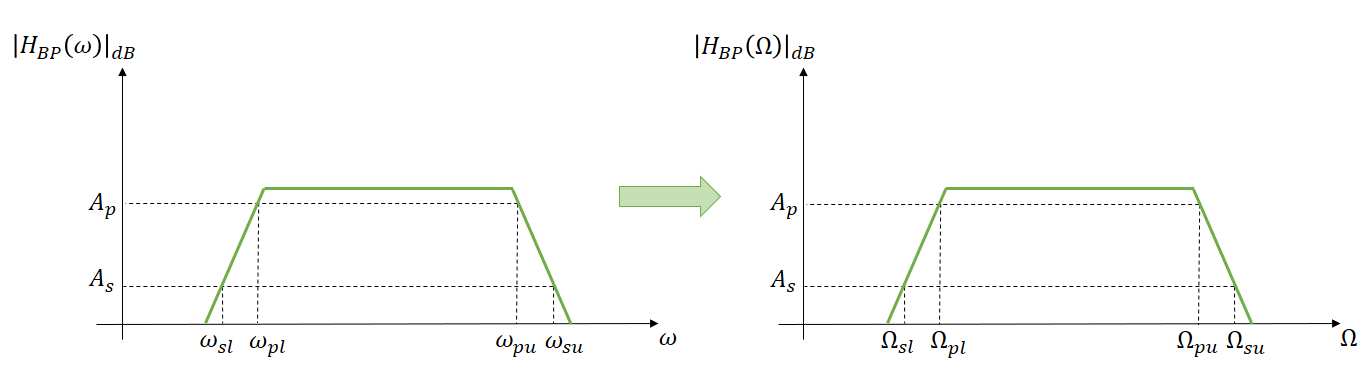

|  |  |
| --- | --- | 
| Lower stop band edge | $\omega_{sl}$ |
| Upper stop band edge | $\omega_{su}$ |
| Lower pass band edge | $\omega_{pl}$ |
| Upper pass band edge | $\omega_{pu}$ |
| Stop band attenuation (dB)  | $Ap$ |
| Pass band attenuation (dB)  | $As$ |


To computer the values in the $\Omega$ domain, we use the transformation below:
$$
\Omega_i = \tan\dfrac{\omega_i}{2}
$$
We also define the following parameters:
$$
Bandwidth: B = \Omega_{pu} - \Omega_{pl}
$$
$$
Center frequency: \Omega_o = \sqrt{\Omega_{pu}\Omega_{pl}}
$$

### Step 2: Maping of the lowpass filter into the bandpass

In this kind of project, we first design a lowpass filter using the Butterworth method, and after that we transform our response in a bandpass filter. In order to do this, there is a transformation in the variable $s$ that make it possible:

$$
s_{LP} = \dfrac{s_{BP}^2+\Omega_o^2}{Bs_{BP}}
$$

Fazendo $s = j\Omega$, então:

$$
\Omega_{LP} = \dfrac{\Omega_{BP}^2 - \Omega_o^2}{B\Omega_{BP}}
$$

In fact, note that, by the formula, $\Omega_{BP} = \Omega_o$ is maped in $\Omega_{LP} = 0$. The same logic we use to define the correspondent frequency $\Omega_s$, and, to facilitate the calculus, we make $\Omega_p = 1$.

$$
\Omega_s = \dfrac{\Omega_{su}^2 - \Omega_o^2}{B\Omega_{su}}
$$

$$
\Omega_p = 1
$$

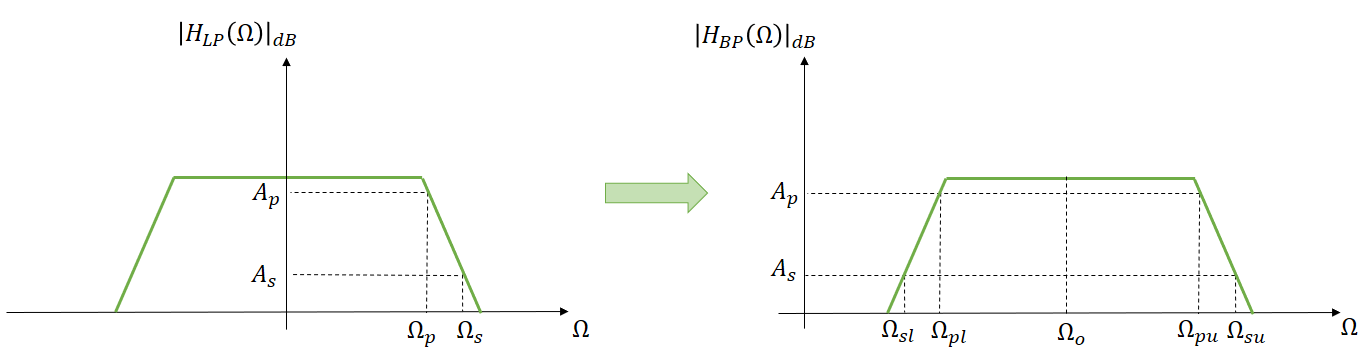

With these parameters, we calculate the order of the correspondent LPF and its cutoff frequency:

$$
N = \dfrac{\log_{10}\left( \dfrac{10^{|A_s|/10} - 1}{10^{|A_p|/10} - 1}  \right)}{2\log_{10}\left(\dfrac{\Omega_s}{\Omega_p}\right)}
$$

$$
\Omega_c = \dfrac{\Omega_s}{\left(10^{|A_s|/10} - 1\right)^{\frac{1}{2N}}}
$$

Now, we are able to calculate the cutoff frequencies of the continuous time BPF, given by:

$$
\Omega_{c1} = -\dfrac{B\Omega_c}{2} + \dfrac{1}{2}\sqrt{B^2\Omega_c^2+4\Omega_o^2} 
$$

$$
\Omega_{c2} = \dfrac{B\Omega_c}{2} + \dfrac{1}{2}\sqrt{B^2\Omega_c^2+4\Omega_o^2}
$$

### Step 3: Modeling the bandpass filter from a lowpass Butterworth filter

By definition, a Butterworth filter of order $N$ has the following expression:

$$
H_N(s) = \dfrac{c}{B_N(s)} = \dfrac{c}{\displaystyle\prod_{k=0}^{N-1}\left(s - e^{j2\pi\frac{(2k+N+1)}{4N}}\right)}
$$

Our BPF will be obtained from this expression making the substituition:

$$
s \to \dfrac{s^2+\Omega_o^2}{(\Omega_{c2} - \Omega_{c1})s} 
$$

Finally, with our frequency response of continuous time filter, we apply the bilinear transformation, using:

$$
s \to \dfrac{1-z^{-1}}{1+z^{-1}}
$$

and get the discrete BPF desired.

In [1]:
import IPython
import wave
import numpy as np
import matplotlib.pyplot as plt
import sympy as smp
from scipy import signal
from scipy.fft import fft, ifft, fftshift, fftfreq
from scipy.io import loadmat, wavfile

In [2]:
def CTfilter(ω_p1, ω_p2, ω_s1, ω_s2, Ap, As, H_CT):
    for i in range(len(ω_p1)):
        Ω_p1 = np.tan(ω_p1[i]/2)
        Ω_p2 = np.tan(ω_p2[i]/2)
        Ω_s1 = np.tan(ω_s1[i]/2)
        Ω_s2 = np.tan(ω_s2[i]/2)
        
        Ωo = np.sqrt(Ω_p2*Ω_p1)
        B  = Ω_p2 - Ω_p1
        
        # Lowpass parameters
        Ωp = 1
        Ωs = (Ω_s2**2 - Ωo**2) / (B*Ω_s2)
        
        N  = np.ceil(np.log10( (10**(abs(As)/10) - 1) / (10**(abs(Ap)/10) - 1) )  / (2*np.log10(Ωs/Ωp)))
        Ωc = Ωs / (10**(abs(As)/10) - 1)**(1/(2*N))
        
        # Cutoff frequencies of BPF in continuous time
        Ωc1 = -B*Ωc/2 + np.sqrt(B**2*Ωc**2 + 4*Ωo**2)/2
        Ωc2 =  B*Ωc/2 + np.sqrt(B**2*Ωc**2 + 4*Ωo**2)/2
        
        # Lowpass design
        sk = np.zeros(int(N))
        H_LP = 1
        for k in range(int(N)):
            sk[k] = np.real(np.exp(1j*2*np.pi * (2*k + N + 1)/(4*N) ))
            H_LP = H_LP / (s - sk[k])
        
        # Bandpass design
        H_BP = H_LP.subs(s, (s**2 + Ωo**2)/((Ωc2 - Ωc1)*s))
        
        H_CT[i] = H_BP.simplify()
        
    return H_CT

## 1 - Original signal in time and frequency domain

In [3]:
audio = wave.open('sinal_1.wav','rb')

fs      = audio.getframerate()                          # Sampling frequency
samples = audio.getnframes()                            # Number of samples
t_max   = samples/fs                                    # Audio duration

sinal_wave = audio.readframes(samples)                  # Returns the signal's values of each sample
sinal_array = np.frombuffer(sinal_wave, dtype=np.int8)  # Converts from byte to int type

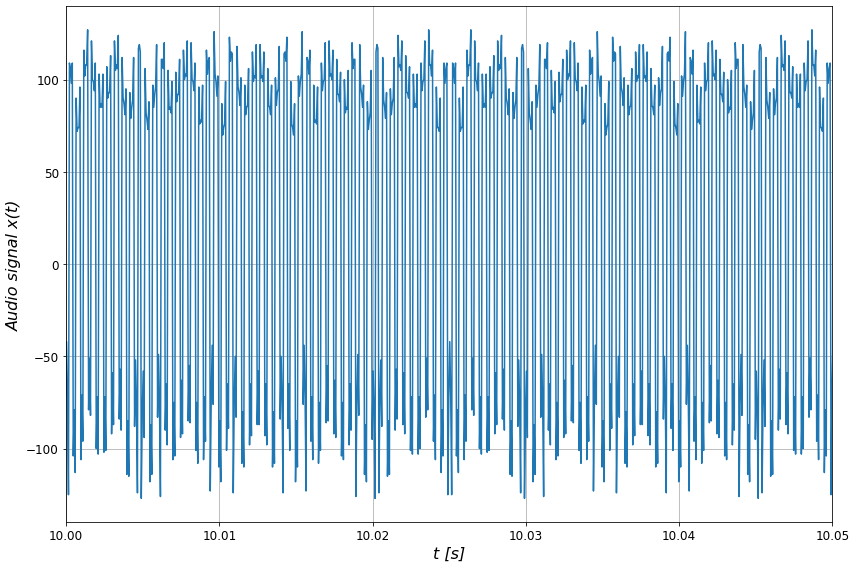

In [4]:
t = np.linspace(0, t_max, samples)

plt.figure(figsize = (12, 8))
plt.plot(t, sinal_array)
plt.xlabel('t [s]', fontsize = 16, fontstyle = 'italic')
plt.ylabel('Audio signal x(t)', fontsize = 16, fontstyle = 'italic')
plt.xlim(10.0, 10.05)
plt.tick_params(axis = 'both', labelsize = 12)
plt.grid()
plt.tight_layout()

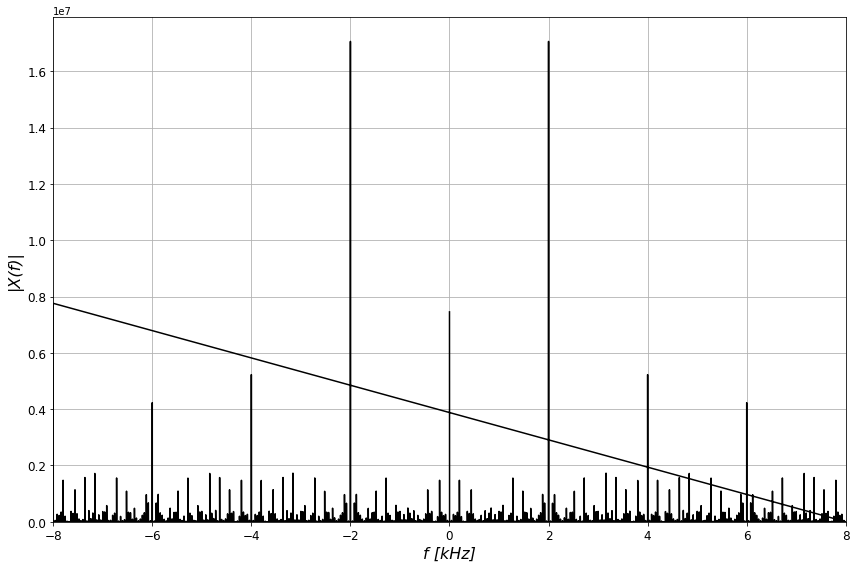

In [5]:
plt.figure(figsize = (12, 8))

f = fs*fftfreq(samples)
plt.plot(1e-3*f, abs(fft(sinal_array, samples)), 'k')

plt.xlabel('f [kHz]', fontsize = 16, fontstyle = 'italic')
plt.ylabel('|X(f)|', fontsize = 16, fontstyle = 'italic')
plt.tick_params(axis = 'both', labelsize = 12)
plt.xlim(-1e-3*fs/2, 1e-3*fs/2)
plt.ylim(0)
plt.tight_layout()
plt.grid()

In [6]:
# Original signal
IPython.display.Audio('sinal_1.wav')

## 2 - Project of the filters

In [7]:
T = len(sinal_array)
s, z = smp.symbols('s z')
H_CT = smp.Matrix([0,0,0])

In [8]:
Ap = -3  
As = -30

f_p1 = np.array([1950, 3950, 5950])
f_p2 = np.array([2050, 4050, 6050])

f_s1 = np.array([1700, 3700, 5700])
f_s2 = np.array([2300, 4300, 6300])

ω_p1 = 2*np.pi*f_p1/fs
ω_p2 = 2*np.pi*f_p2/fs

ω_s1 = 2*np.pi*f_s1/fs
ω_s2 = 2*np.pi*f_s2/fs

In [10]:
H_BP = CTfilter(ω_p1, ω_p2, ω_s1, ω_s2, Ap, As, H_CT)  # Calculates the continuous time expressions for the bandpass filters
H_Z = H_BP.subs(s, (1-z**-1)/(1 + z**-1))              # Calculates the Z-domain filters

### 2.1 - Filter in $2\ kHz$

In [11]:
H_Z[0].simplify().evalf(5)

(1.0*z**4 - 2.0*z**2 + 1.0)/(2580.0*z**4 - 7197.0*z**3 + 10035.0*z**2 - 6996.6*z + 2438.3)

Reorganizing:

$$
H_{BP}(z) = \dfrac{0.000387 - 0.0007752z^{-2} + 0.000387z^{-4}}{1 - 2.7895z^{-1} + 3.8895z^{-2} - 2.71186z^{-3} + 0.9451z^{-4}}
$$

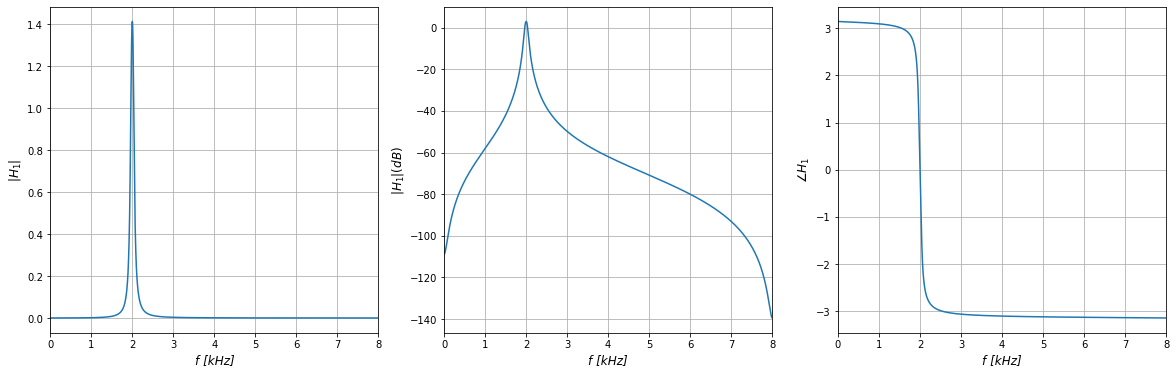

In [25]:
fig, axs = plt.subplots(1, 3, figsize = (20, 6))

b = np.array([0.000387, 0, -0.0007752, 0, 0.000387])
a = np.array([1, -2.7895, 3.8895, -2.71186, 0.9451])

w1, H1 = signal.freqz(b, a, int(T/2))

axs[0].plot(1e-3*fs*w1/(2*np.pi), abs(H1))
axs[0].set_xlabel('f [kHz]', fontsize = 12, fontstyle = 'italic')
axs[0].set_ylabel(r'$|H_1|$', fontsize = 12, fontstyle = 'italic')
axs[0].set_xlim(0, 1e-3*fs/2)
axs[0].grid()

axs[1].plot(1e-3*fs*w1/(2*np.pi), 20*np.log10(abs(H1)))
axs[1].set_xlabel('f [kHz]', fontsize = 12, fontstyle = 'italic')
axs[1].set_ylabel(r'$|H_1| (dB)$', fontsize = 12, fontstyle = 'italic')
axs[1].set_xlim(0, 1e-3*fs/2)
axs[1].grid()

axs[2].plot(1e-3*fs*w1/(2*np.pi), np.unwrap(np.angle(H1)))
axs[2].set_xlabel('f [kHz]', fontsize = 12, fontstyle = 'italic')
axs[2].set_ylabel(r'$\angle{H_1}$', fontsize = 12, fontstyle = 'italic')
axs[2].set_xlim(0, 1e-3*fs/2)
axs[2].grid()

### 2.2 - Filter in $4\ kHz$

In [19]:
H_Z[1].simplify().evalf(5)

(1.0*z**4 - 2.0*z**2 + 1.0)/(2323.9*z**4 - 6.8507e-13*z**3 + 4511.5*z**2 - 6.6497e-13*z + 2189.6)

$$
H_{BP}(z) = \dfrac{0.00043 - 0.00086z^{-2} + 0.00043z^{-4}}{1 + 1.9413z^{-2} + 0.94221z^{-4} }
$$

<ipython-input-24-c0392889327b>:14: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(1e-3*fs*w2/(2*np.pi), 20*np.log10(abs(H2)))


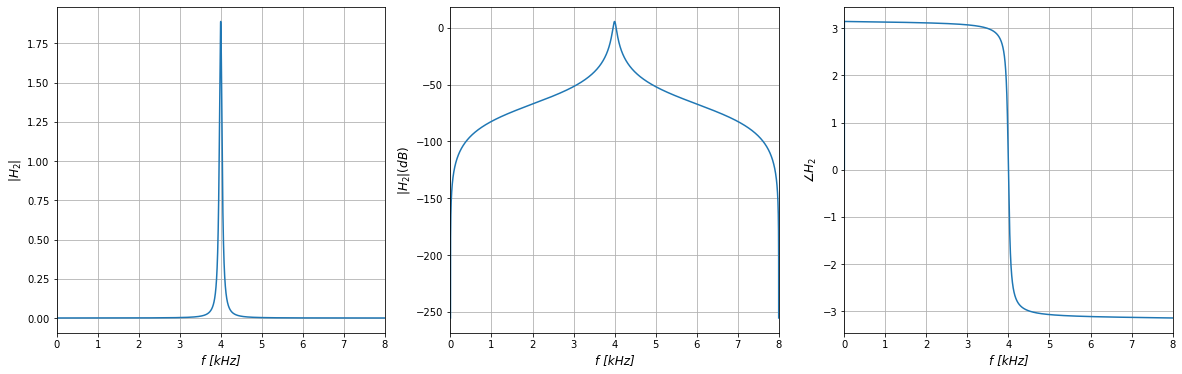

In [24]:
fig, axs = plt.subplots(1, 3, figsize = (20, 6))

b = np.array([0.00043, 0, -0.00086, 0, 0.00043])
a = np.array([1, 0, 1.9413, 0, 0.94221])

w2, H2 = signal.freqz(b, a, int(T/2))

axs[0].plot(1e-3*fs*w2/(2*np.pi), abs(H2))
axs[0].set_xlabel('f [kHz]', fontsize = 12, fontstyle = 'italic')
axs[0].set_ylabel(r'$|H_2|$', fontsize = 12, fontstyle = 'italic')
axs[0].set_xlim(0, 1e-3*fs/2)
axs[0].grid()

axs[1].plot(1e-3*fs*w2/(2*np.pi), 20*np.log10(abs(H2)))
axs[1].set_xlabel('f [kHz]', fontsize = 12, fontstyle = 'italic')
axs[1].set_ylabel(r'$|H_2| (dB)$', fontsize = 12, fontstyle = 'italic')
axs[1].set_xlim(0, 1e-3*fs/2)
axs[1].grid()

axs[2].plot(1e-3*fs*w2/(2*np.pi), np.unwrap(np.angle(H2)))
axs[2].set_xlabel('f [kHz]', fontsize = 12, fontstyle = 'italic')
axs[2].set_ylabel(r'$\angle{H_2}$', fontsize = 12, fontstyle = 'italic')
axs[2].set_xlim(0, 1e-3*fs/2)
axs[2].grid()

### 2.3 - Filter in $6\ kHz$

In [21]:
H_Z[2].simplify().evalf(5)

(1.0*z**4 - 2.0*z**2 + 1.0)/(2050.9*z**4 + 5711.5*z**3 + 7950.1*z**2 + 5533.1*z + 1924.9)

$$
H_{BP}(z) = \dfrac{0.000487 - 0.000975z^{-2} + 0.000487z^{-4}}{1 + 2.785z^{-1} + 3.876z^{-2} + 2.698z^{-3} + 0.938z^{-4}}
$$

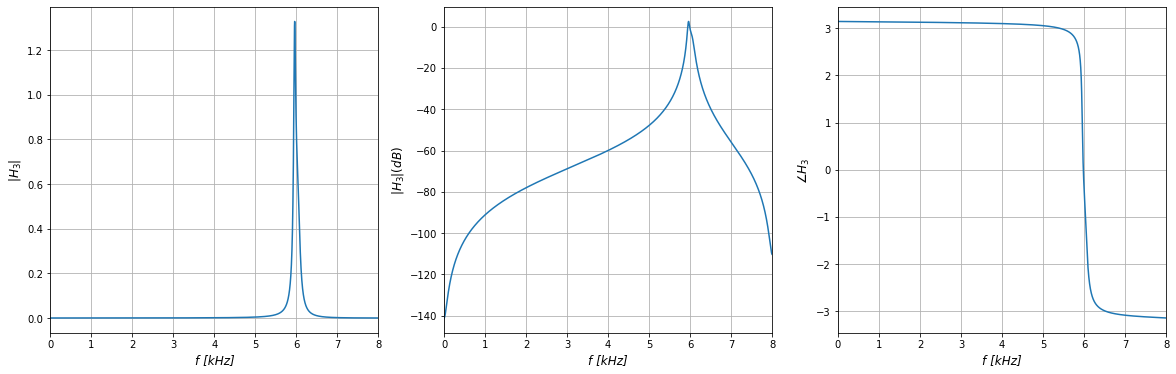

In [23]:
fig, axs = plt.subplots(1, 3, figsize = (20, 6))

b = np.array([0.000487, 0, -0.000975, 0, 0.000487])
a = np.array([1, 2.785, 3.876, 2.698, 0.938])

w3, H3 = signal.freqz(b, a, int(T/2))

axs[0].plot(1e-3*fs*w3/(2*np.pi), abs(H3))
axs[0].set_xlabel('f [kHz]', fontsize = 12, fontstyle = 'italic')
axs[0].set_ylabel(r'$|H_3|$', fontsize = 12, fontstyle = 'italic')
axs[0].set_xlim(0, 1e-3*fs/2)
axs[0].grid()

axs[1].plot(1e-3*fs*w3/(2*np.pi), 20*np.log10(abs(H3)))
axs[1].set_xlabel('f [kHz]', fontsize = 12, fontstyle = 'italic')
axs[1].set_ylabel(r'$|H_3| (dB)$', fontsize = 12, fontstyle = 'italic')
axs[1].set_xlim(0, 1e-3*fs/2)
axs[1].grid()

axs[2].plot(1e-3*fs*w3/(2*np.pi), np.unwrap(np.angle(H3)))
axs[2].set_xlabel('f [kHz]', fontsize = 12, fontstyle = 'italic')
axs[2].set_ylabel(r'$\angle{H_3}$', fontsize = 12, fontstyle = 'italic')
axs[2].set_xlim(0, 1e-3*fs/2)
axs[2].grid()

## 3 - Separating the harmonics

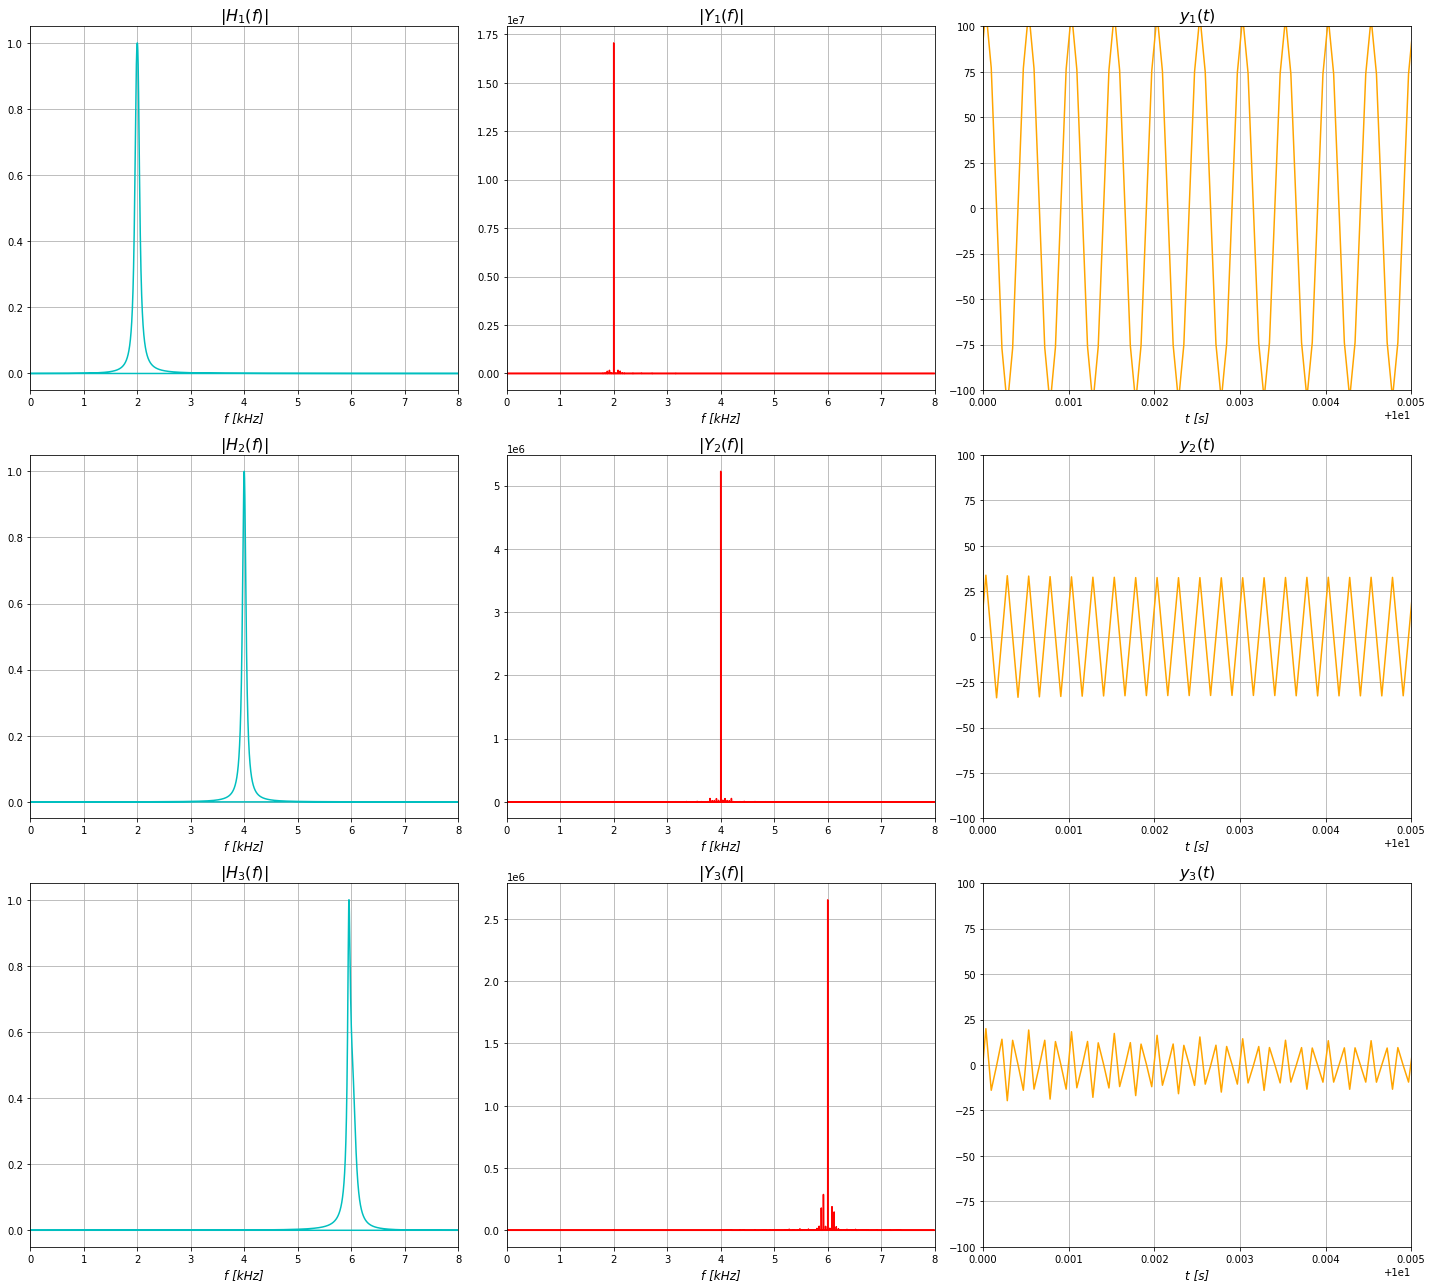

In [26]:
fig, axs = plt.subplots(3,3, figsize = (20, 18))

H = np.array([H1/max(abs(H1)), H2/max(abs(H2)), H3/max(abs(H3))])

for i in range(3):
    f = fs*fftfreq(T)

    Hf = np.concatenate((H[i], np.flip(H[i])))
    Y = (abs(fft(sinal_array))) * (abs(Hf))
    y = np.real(ifft(Y))
    t = np.linspace(0, t_max, T)
    
    axs[i,0].plot(1e-3*f, abs(Hf),'c')
    axs[i,0].set_xlabel('f [kHz]', fontsize = 12, fontstyle = 'italic')
    axs[i,0].set_title('$|H_'+str(i+1)+'(f)|$', fontsize = 16, fontweight = 'bold')
    axs[i,0].set_xlim(0, 1e-3*fs/2)
    axs[i,0].grid()
    
    axs[i,1].plot(1e-3*f, abs(Y),'r')
    axs[i,1].set_xlabel('f [kHz]', fontsize = 12, fontstyle = 'italic')
    axs[i,1].set_title('$|Y_'+str(i+1)+'(f)|$', fontsize = 16, fontweight = 'bold')
    axs[i,1].set_xlim(0, 1e-3*fs/2)
    axs[i,1].grid()
    
    axs[i,2].plot(t, y, 'orange')
    axs[i,2].set_xlabel('t [s]', fontsize = 12, fontstyle = 'italic')
    axs[i,2].set_title('$y_'+str(i+1)+'(t)$', fontsize = 16, fontweight = 'bold')
    axs[i,2].set_ylim(-100, 100)
    axs[i,2].set_xlim(10, 10.005)
    axs[i,2].grid()
    
    wavfile.write('Harm_'+str(i+1)+'.wav', int(fs), y.astype(np.float32))
    
plt.tight_layout()

In [27]:
# Harmonic of 2 kHz
IPython.display.Audio('Harm_1.wav')

In [28]:
# Harmonic of 4 kHz
IPython.display.Audio('Harm_2.wav')

In [29]:
# Harmonic of 6 kHz
IPython.display.Audio('Harm_3.wav')